<a href="https://colab.research.google.com/github/sarathharigovindam/minorproject/blob/main/srcsmdtctn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [159]:
import json
import tensorflow as tf
import sklearn

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense
#import Sequential from sklearn.preprocessing 
#import MinMaxScaler from keras.layers 
#!pip install Dense
#import Dense, Dropout, Activation, Flatten, LSTM 

In [160]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [161]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-12-14 18:34:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2021-12-14 18:34:48 (141 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [162]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [163]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [164]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [165]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [166]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [167]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(65, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [168]:
model1.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 24)                408       
                                                                 
 dense_19 (Dense)            (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [169]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 16)           160000    
                                                                 
 bidirectional_18 (Bidirecti  (None, 100, 256)         148480    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 100, 130)         167440    
 onal)                                                           
                                                                 
 bidirectional_20 (Bidirecti  (None, 256)              199680    
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                     

In [170]:
num_epochs = 10
history1 = model1.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
625/625 - 4s - loss: 0.6633 - accuracy: 0.5822 - val_loss: 0.5848 - val_accuracy: 0.7606 - 4s/epoch - 6ms/step
Epoch 2/10
625/625 - 3s - loss: 0.4414 - accuracy: 0.8240 - val_loss: 0.3879 - val_accuracy: 0.8396 - 3s/epoch - 4ms/step
Epoch 3/10
625/625 - 3s - loss: 0.3126 - accuracy: 0.8763 - val_loss: 0.3527 - val_accuracy: 0.8550 - 3s/epoch - 5ms/step
Epoch 4/10
625/625 - 3s - loss: 0.2589 - accuracy: 0.8986 - val_loss: 0.3441 - val_accuracy: 0.8547 - 3s/epoch - 5ms/step
Epoch 5/10
625/625 - 3s - loss: 0.2233 - accuracy: 0.9152 - val_loss: 0.3434 - val_accuracy: 0.8571 - 3s/epoch - 5ms/step
Epoch 6/10
625/625 - 3s - loss: 0.1948 - accuracy: 0.9262 - val_loss: 0.3551 - val_accuracy: 0.8557 - 3s/epoch - 5ms/step
Epoch 7/10
625/625 - 3s - loss: 0.1734 - accuracy: 0.9347 - val_loss: 0.3941 - val_accuracy: 0.8390 - 3s/epoch - 5ms/step
Epoch 8/10
625/625 - 3s - loss: 0.1548 - accuracy: 0.9434 - val_loss: 0.3811 - val_accuracy: 0.8523 - 3s/epoch - 5ms/step
Epoch 9/10
625/625 - 3s 

In [171]:
num_epochs = 10
history2 = model2.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
625/625 - 132s - loss: 0.4009 - accuracy: 0.8062 - val_loss: 0.3362 - val_accuracy: 0.8538 - 132s/epoch - 211ms/step
Epoch 2/10
625/625 - 120s - loss: 0.2161 - accuracy: 0.9127 - val_loss: 0.3360 - val_accuracy: 0.8538 - 120s/epoch - 193ms/step
Epoch 3/10
625/625 - 119s - loss: 0.1335 - accuracy: 0.9488 - val_loss: 0.5125 - val_accuracy: 0.8480 - 119s/epoch - 191ms/step
Epoch 4/10
625/625 - 119s - loss: 0.0811 - accuracy: 0.9711 - val_loss: 0.5489 - val_accuracy: 0.8456 - 119s/epoch - 191ms/step
Epoch 5/10
625/625 - 119s - loss: 0.0441 - accuracy: 0.9855 - val_loss: 0.6574 - val_accuracy: 0.8447 - 119s/epoch - 191ms/step
Epoch 6/10
625/625 - 120s - loss: 0.0419 - accuracy: 0.9854 - val_loss: 0.6755 - val_accuracy: 0.8411 - 120s/epoch - 192ms/step
Epoch 7/10
625/625 - 121s - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.7266 - val_accuracy: 0.8302 - 121s/epoch - 193ms/step
Epoch 8/10
625/625 - 120s - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.9987 - val_accuracy: 0.8383 - 

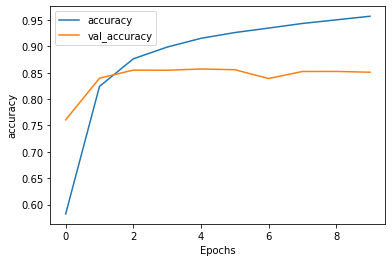

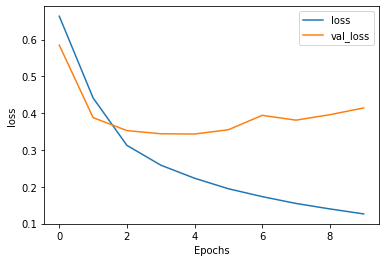

In [172]:
import matplotlib.pyplot as plt


def plot_graphs(history1, string):
  plt.plot(history1.history[string])
  plt.plot(history1.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

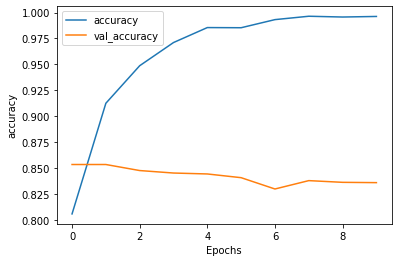

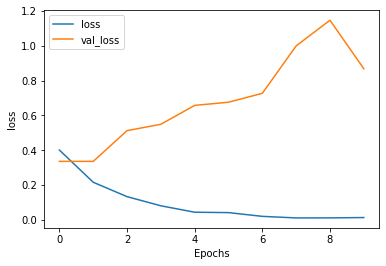

In [173]:
def plot_graphs(history2, string):
  plt.plot(history2.history[string])
  plt.plot(history2.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [189]:
train_acc1=history1.history['val_accuracy']
print(train_acc1)

[0.7606200575828552, 0.839618444442749, 0.8549709320068359, 0.8546728491783142, 0.8570576906204224, 0.8557162284851074, 0.8390222191810608, 0.8522879481315613, 0.8524370193481445, 0.8509464859962463]


In [190]:
train_acc2=history2.history['val_accuracy']
print(train_acc2)

[0.8537784814834595, 0.8537784814834595, 0.84796541929245, 0.8455805778503418, 0.8446862697601318, 0.8411089777946472, 0.8302280306816101, 0.8382769227027893, 0.8366373777389526, 0.8363392353057861]


In [176]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [177]:
e = model2.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [178]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [179]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [206]:
sentence = ["if you study well,then you will get bad marks"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model1.predict(padded))
print(model2.predict(padded))
if train_acc2[-1] > train_acc1[-1]:
  print(model2.predict(padded))
else:
  print(model1.predict(padded))

[[0.9557483]]
[[0.14377627]]
[[0.9557483]]
